<a href="https://colab.research.google.com/github/soustan/Internship-Data-Analitic/blob/main/%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D0%B4%D0%BE%D1%87%D0%BD%D1%8B%D0%B9-%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7-EDA-%D0%A1%D1%83%D1%85%D0%BE%D1%80%D1%83%D0%BA%D0%BE%D0%B2-%D0%A1%D1%82%D0%B0%D0%BD%D0%B8%D1%81%D0%BB%D0%B0%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
! gdown 1nW6WHg7oW9O_FE3qM-HX6ZKgznPjjRee

df = pd.read_excel('/content/region roles (26.05.22).xlsx')

Downloading...
From: https://drive.google.com/uc?id=1nW6WHg7oW9O_FE3qM-HX6ZKgznPjjRee
To: /content/region roles (26.05.22).xlsx
100% 84.4M/84.4M [00:00<00:00, 92.3MB/s]


После загрузки и считывания датасета из файла следует провести первичный осмотр датасета. Это можно сделать с помощью метода .info(). По выведенной сводной таблице можно узнать, что у датасета 69656 записей и 34 колонки. Из этих 34 колонок пропуски имеются в колонке "department" (Отдел), "salary" (Зарплата), "address" (Адрес), "response_url", "sort_point_distance", "insider_interview", "contacts" (Контакты) и "immediate_redirect_url".

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69656 entries, 0 to 69655
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                69656 non-null  int64  
 1   id                        69656 non-null  int64  
 2   premium                   69656 non-null  bool   
 3   name                      69656 non-null  object 
 4   department                5263 non-null   object 
 5   has_test                  69656 non-null  bool   
 6   response_letter_required  69656 non-null  bool   
 7   area                      69656 non-null  object 
 8   salary                    37590 non-null  object 
 9   type                      69656 non-null  object 
 10  address                   40318 non-null  object 
 11  response_url              1 non-null      object 
 12  sort_point_distance       0 non-null      float64
 13  published_at              69656 non-null  object 
 14  create

Основным источником числовых значений для анализа можно признать колонку "salary" (Зарплата). Однако данные в этой колонке представлены в виде JSON-объекта с позициями "from" (нижний порог зарплаты), "to" (верхний порог зарплаты), "currency" (валюта зарплаты) и "gross" (До вычета). Необходимо достать из JSON-объекта эти числовые данные, с учётом соответствующих параметров валюты и налогообложения, чтобы можно было использовать их в анализе. 

In [3]:
import json

df['salary_json'] = df['salary'].fillna('{}').apply(eval)

def get_values_from(json):
    try:
        return json['from']
    except:
        return None

def get_values_to(json):
    try:
        return json['to']
    except:
        return None

def get_currency(json):
    try:
        return json['currency']
    except:
        return None

def get_gross(json):
    try:
        return json['gross']
    except:
        return None

df['salary_from'] = df['salary_json'].apply(get_values_from)
df['salary_to'] = df['salary_json'].apply(get_values_to)
df['salary_currency'] = df['salary_json'].apply(get_currency)
df['salary_gross'] = df['salary_json'].apply(get_gross)

for i in range(len(df['salary_currency'])):
    if df['salary_currency'][i] == 'USD': 
        df['salary_from'][i] *= 56.3
        df['salary_to'][i] *= 56.3
        df['salary_currency'][i] = 'RUR'
    elif df['salary_currency'][i] == 'EUR':
        df['salary_from'][i] *= 58
        df['salary_to'][i] *= 58
        df['salary_currency'][i] = 'RUR'
    elif df['salary_currency'][i] == 'KZT':
        df['salary_from'][i] *= 0.13
        df['salary_to'][i] *= 0.13
        df['salary_currency'][i] = 'RUR'
    i += 1  

for j in range(len(df['salary_gross'])):
    if df['salary_gross'][j] == 'True':
        df['salary_from'][j] *= 0.87
        df['salary_to'][j] *= 0.87
    j += 1
df['salary_gross'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to b

count     37575
unique        2
top       False
freq      25531
Name: salary_gross, dtype: object

В рамках исследования датасета будут проанализированы значения колонок "salary" (Зарплата), "specializations" (Сферы труда), "experience" (Опыт работы) и "region" (Регион). Сперва будут вычислены основные статистические показатели. Затем будет проводиться сопоставление колонок для выявления взаимосвязи между тенденциями в их значениях. Колонки будут сопоставляться по количественным и категориальным аспектам: будут проанализированы соотношения как по числу значений у разных групп по двум колонкам, так и соотношения с числовыми значениями колонки "Зарплата". 

Сначала вычислим основные статистические показатели.

In [4]:
#df['salary_from'].describe().apply(int)
df['salary_to'].describe().apply(int)

count       19956
mean       136186
std        184029
min            40
25%         50000
50%         90000
75%        168000
max      10000000
Name: salary_to, dtype: int64

Начальная зарплата в датасете: минимальная (не считая пропусков) = 12 рублей; первый квартиль = 40000 рублей; медиана = 60000 рублей; среднее значение = 77960 рублей; третий квартиль = 100000 рублей, максимум = 2000000 рублей. Всего значений: 34074, стандартное отклонение = 67444.

Конечная зарплата в датасете: минимальная = 40 рублей; первый квартиль = 50000 рублей, медиана = 90000 рублей, среднее значение = 136187 рублей, третий квартиль = 168000 рублей, максимальная = 10000000 рублей. Всего ненулевых значений: 19956, стандартное отклонение = 184029.



Сделаем графический анализ числовых данных. Для этого сперва нужно удалить пропуски. Это можно сделать с помощью метода .dropna(); но, поскольку в датасете представлены запредельно низкие ненулевые показатели зарплат, будет лучше отфильтровать датасет. В качестве фильтра будет выступать размер МРОТ в России, по которому будет отдельно сделаны фильтры для начальной и конечной зарплат. В качестве модели графика можно выбрать боксплот, удобный для отображения числовых данных. Для более чёткой отрисовки боксплота можно задать ему ограничения с помощью метода .axis().

In [5]:
filter_mrot_from = (df['salary_from'] > 15279)
filter_mrot_to = (df['salary_to'] > 15279)
filtered_df_mrot_from = df[filter_mrot_from]
filtered_df_mrot_to = df[filter_mrot_to]
salary_from_filtered = filtered_df_mrot_from['salary_from'].apply(int)
salary_to_filtered = filtered_df_mrot_to['salary_to'].apply(int)
salary_from_filtered.describe().apply(int)
#salary_to_filtered.describe().apply(int)

count      32866
mean       80330
std        67506
min        15500
25%        40000
50%        60000
75%       100000
max      2000000
Name: salary_from, dtype: int64

После применения фильтра по МРОТ число значений у каждой из зарплат уменьшилось: у начальной зарплаты - 32866, у конечной зарплаты - 19903.

Отфильтрованная начальная зарплата: минимальная = 15500 рубля; первый квартиль = 40000 рублей; медиана = 60000 рублей; среднее значение = 80330 рубль; третий квартиль = 100000 рублей, максимум = 2000000 рублей, стандартное отклонение = 67506.

Отфильтрованная конечная зарплата: минимальная = 15800 рублей; первый квартиль = 50000 рублей, медиана = 90000 рублей, среднее значение = 136520 рублей, третий квартиль = 168900 рублей, максимальная = 10000000 рублей, стандартное отклонение = 184160.

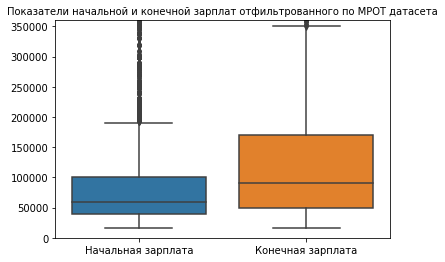

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df_salary_filtered = pd.DataFrame()
df_salary_filtered['salary_from'] = salary_from_filtered
df_salary_filtered['salary_to'] = salary_to_filtered
ax = sns.boxplot(data=df_salary_filtered)
ax.set_xticklabels(['Начальная зарплата', 'Конечная зарплата'])
plt.title('Показатели начальной и конечной зарплат отфильтрованного по МРОТ датасета', fontsize=10)
plt.axis(ymin=0, ymax=360000)
plt.show()


Для начальной зарплаты можно выявить, что основные характерные её показатели лежат в пределах от 15 000 до 175 000 рублей. Судя по тому, что медиана на графике лежит гораздо ближе к первому квартилю, а также по тому, что среднее значение значительно превышает медианное, вакансий с начальной зарплатой выше медианы значительно больше, чем вакансий с зарплатой ниже медианы. Большая часть выбросов лежит в пределах 300 000-400 000 рублей.

Для конечной зарплаты выявляется больший разброс данных между первым и третьим квартилями (от 50 000 до 170 000 рублей); верхняя граница характерных данных лежит в районе 350 000 рублей, в то время как нижняя граница находится там же, где и у начальной зарплаты, в районе 16 000 рублей. Как и у начальной зарплаты, отметка медианы значительно ближе к первому квартилю, в силу чего вакансий с зарплатой выше медианной больше, чем вакансий с зарплатой ниже медианы. Большая часть выбросов лежит в пределах 1 000 000 рублей. 

Если минимальные значения и первый квартиль у начальной и конечной зарплат отличаются ненамного, то уже их медианы различаются на десятки тысяч рублей.

Далее проведём анализ категориальных данных. Начать можно с колонки "experience" (Опыт работы).

In [7]:
#df['experience'].describe()
#df['experience'].unique()
#df['experience'].value_counts()
filtered_df_mrot_from['experience'].value_counts()
#filtered_df_mrot_to['experience'].value_counts()

{'id': 'between1And3', 'name': 'От 1 года до 3 лет'}    16300
{'id': 'noExperience', 'name': 'Нет опыта'}              8820
{'id': 'between3And6', 'name': 'От 3 до 6 лет'}          7006
{'id': 'moreThan6', 'name': 'Более 6 лет'}                740
Name: experience, dtype: int64

У колонки "Опыт работы" значения содержатся в словарях в виде JSON-объектов. Метод .describe() показал, что пропусков нет, а метод .unique() показал, что всего представлены 4 значения - "Нет опыта", "От 1 до 3 лет", "От 3 до 6 лет", "Более 6 лет". Метод .value_counts() выявил, что больше всего вакансий с требованием к опыту 1-3 года (34989), на втором месте - опыт 3-6 лет (19823), на третьем месте - без опыта (12646) и меньше всего вакансий с запросом опыта от 6 лет (2198). 

По этим данным можно сделать вывод, что работодатели в сфере IT в основном ищут людей с рабочим опытом, даже если он и небольшой. Можно предположить, что кандидаты с опытом 1-3 года относятся к junior-специалистам, с опытом 3-6 лет - к middle-специалистам, а более 6 лет - к senior-специалистам; из чего можно сделать вывод, что большинство вакансий - джуновские и мидловские; вакансий старших специалистов меньше всего, что ожидаемо в силу меньшего числа руководительских позиций. 

Если же посмотреть сводку по отфильтрованной по МРОТ колонке, то число вакансий с указанной и реалистичной зарплатой для кандидатов без опыта даже больше, чем вакансий для middle-специалистов. Разница в числе вакансий заметно сократилась, но джуновских вакансий по-прежнему почти в два раза больше, чем у второго места (в данном случае, у кандидатов без опыта).

Далее можно проанализировать данные колонки "specializations" (Специальности).

In [8]:
#df['specializations'].describe()
for l in range(100):
    print(df['specializations'][l])

[{'id': '1.172', 'name': 'Начальный уровень, Мало опыта', 'profarea_id': '1', 'profarea_name': 'Информационные технологии, интернет, телеком'}, {'id': '1.117', 'name': 'Тестирование', 'profarea_id': '1', 'profarea_name': 'Информационные технологии, интернет, телеком'}, {'id': '15.93', 'name': 'Информационные технологии, Интернет, Мультимедиа', 'profarea_id': '15', 'profarea_name': 'Начало карьеры, студенты'}]
[{'id': '1.221', 'name': 'Программирование, Разработка', 'profarea_id': '1', 'profarea_name': 'Информационные технологии, интернет, телеком'}, {'id': '1.82', 'name': 'Инженер', 'profarea_id': '1', 'profarea_name': 'Информационные технологии, интернет, телеком'}, {'id': '1.117', 'name': 'Тестирование', 'profarea_id': '1', 'profarea_name': 'Информационные технологии, интернет, телеком'}]
[{'id': '1.221', 'name': 'Программирование, Разработка', 'profarea_id': '1', 'profarea_name': 'Информационные технологии, интернет, телеком'}, {'id': '1.82', 'name': 'Инженер', 'profarea_id': '1', '

Метод .describe() показывает, что пропусков нет, а уникальных значений слишком много, чтобы можно было разбить колонку на группы. Просмотр среза записей колонки (вывод через цикл на определённое число элементов) прояснил, что записи содержат строковое изложение списка из JSON-объектов, которые содержат: название специальности и её id, название сферы труда и её id. Количество JSON-объектов в списке варьируется от 1 до, судя по первым 100 элементам, 5 объектов. Поскольку в исследовании рассматриваются IT-вакансии, то в колонке "Специализации" нужны в первую очередь вакансии сферы "Информационные технологии, интернет, телеком". Так как количество объектов внутри записи варьируется, их можно вывести в несколько новых колонок по названию сферы труда.

Алгоритм следующий:

- Содержимое записей по колонке преобразуется в список JSON-объектов; 

- Для каждого из столбцов создаётся функция извлечения названия сферы труда и функция извлечения названия специализации;

- Создаются соответствующие 5 столбцов с названиями сфер труда и 5 столбцов с названием специализации;

- Создаются 5 новых Series-столбцов для фильтрации столбцов с названием специализации, чтобы оставить только те названия специализации, которые соответствуют лишь сфере труда "Информационные технологии, интернет, телеком"; заполняются с помощью цикла с перебором всех элементов столбцов;

- Создаётся дополнительный датафрейм, в который колонками заносятся отфильтрованные столбцы названий специализаций;

- В отдельную переменную копируется этот датафрейм, к которому применили функцию подсчёта значений - то есть, в переменной будет датафрейм, в котором записи - названия специализаций, а в колонках - соответствующие им количества из датасета для каждого из столбцов; 

- Значения NaN заменяются нулями;

- Создаётся колонка 'sum', в которую заносится сумма значений по одной записи.

In [9]:
import numpy as np

df['specializations_json'] = [eval(row) for row in df['specializations']]

def return_indexed_profarea_0(data):
    try:
        return data[0]['profarea_name']
    except:
        return None

def return_indexed_profarea_1(data):
    try:
        return data[1]['profarea_name']
    except:
        return None

def return_indexed_profarea_2(data):
    try:
        return data[2]['profarea_name']
    except:
        return None

def return_indexed_profarea_3(data):
    try:
        return data[3]['profarea_name']
    except:
        return None

def return_indexed_profarea_4(data):
    try:
        return data[4]['profarea_name']
    except:
        return None

def return_indexed_name_0(data):
    try:
        return data[0]['name']
    except:
        return None

def return_indexed_name_1(data):
    try:
        return data[1]['name']
    except:
        return None

def return_indexed_name_2(data):
    try:
        return data[2]['name']
    except:
        return None

def return_indexed_name_3(data):
    try:
        return data[3]['name']
    except:
        return None

def return_indexed_name_4(data):
    try:
        return data[4]['name']
    except:
        return None

df['specializations_profarea_0'] = df['specializations_json'].apply(return_indexed_profarea_0)
df['specializations_profarea_1'] = df['specializations_json'].apply(return_indexed_profarea_1)
df['specializations_profarea_2'] = df['specializations_json'].apply(return_indexed_profarea_2)
df['specializations_profarea_3'] = df['specializations_json'].apply(return_indexed_profarea_3)
df['specializations_profarea_4'] = df['specializations_json'].apply(return_indexed_profarea_4)
df['specializations_name_0'] = df['specializations_json'].apply(return_indexed_name_0)
df['specializations_name_1'] = df['specializations_json'].apply(return_indexed_name_1)
df['specializations_name_2'] = df['specializations_json'].apply(return_indexed_name_2)
df['specializations_name_3'] = df['specializations_json'].apply(return_indexed_name_3)
df['specializations_name_4'] = df['specializations_json'].apply(return_indexed_name_4)
df['specializations_name_filtered_0'] = pd.Series()
df['specializations_name_filtered_1'] = pd.Series() 
df['specializations_name_filtered_2'] = pd.Series()
df['specializations_name_filtered_3'] = pd.Series() 
df['specializations_name_filtered_4'] = pd.Series()
for m in range(len(df['specializations'])):
    if df['specializations_profarea_0'][m] == 'Информационные технологии, интернет, телеком':
        df['specializations_name_filtered_0'][m] = df['specializations_name_0'][m]
    elif df['specializations_profarea_1'][m] == 'Информационные технологии, интернет, телеком':
        df['specializations_name_filtered_1'][m] = df['specializations_name_1'][m]
    elif df['specializations_profarea_2'][m] == 'Информационные технологии, интернет, телеком':
        df['specializations_name_filtered_2'][m] = df['specializations_name_2'][m]
    elif df['specializations_profarea_3'][m] == 'Информационные технологии, интернет, телеком':
        df['specializations_name_filtered_3'][m] = df['specializations_name_3'][m]
    elif df['specializations_profarea_4'][m] == 'Информационные технологии, интернет, телеком':
        df['specializations_name_filtered_4'][m] = df['specializations_name_4'][m]
    m += 1

df_s_n_f = pd.DataFrame()
df_s_n_f['0'] = df['specializations_name_filtered_0']
df_s_n_f['1'] = df['specializations_name_filtered_1']
df_s_n_f['2'] = df['specializations_name_filtered_2']
df_s_n_f['3'] = df['specializations_name_filtered_3']
df_s_n_f['4'] = df['specializations_name_filtered_4']
df_s_n_f_vc = df_s_n_f.apply(pd.Series.value_counts)
df_s_n_f_vc = df_s_n_f_vc.fillna(0).astype(int)
df_s_n_f_vc['sum'] = df_s_n_f_vc.sum(axis=1)
df_s_n_f_vc_other = 0
for s in range(len(df_s_n_f_vc)):
    if df_s_n_f_vc['sum'][s] < 1000:
        df_s_n_f_vc_other += df_s_n_f_vc['sum'][s]
    s += 1
df_s_n_f_vc_top7 = df_s_n_f_vc.nlargest(n=7, columns=['sum'])
df_s_n_f_vc_values = []
for s1 in df_s_n_f_vc_top7['sum']:
    df_s_n_f_vc_values.append(s1)
df_s_n_f_vc_values.append(df_s_n_f_vc_other)
df_s_n_f_vc_index = []
for s2 in df_s_n_f_vc_top7.index:
    df_s_n_f_vc_index.append(s2)
df_s_n_f_vc_index.append('Другое')
df_s_n_f_vc.sort_values('sum', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: Deprecation

,0,1,2,3,4,sum
"Программирование, Разработка",21337,10,6,0,3,21356
Сетевые технологии,6974,2,1,0,0,6977
Аналитик,29,5675,3,3,1,5711
"Начальный уровень, Мало опыта",5591,5,1,0,0,5597
Управление проектами,15,3240,5,5,3,3268
Игровое ПО,2890,0,0,0,0,2890
Компьютерная безопасность,2833,4,0,0,0,2837
"CTO, CIO, Директор по IT",2,589,0,0,0,591
Технический писатель,478,0,0,0,0,478
Арт-директор,149,0,0,0,0,149


Подблок вычисления основных сфер труда среди вакансий.
Алгоритм:
- Складывание числа значений для всех сфер труда и выявление из них наиболее часто встречающихся; 

- Подсчёт по названиям сфер труда по их количеству среди всех вакансий с помощью цикла и счётчика.

In [10]:
df_spec_prof_sum = (df['specializations_profarea_0'].value_counts() + 
                    df['specializations_profarea_1'].value_counts() +
                    df['specializations_profarea_2'].value_counts() + 
                    df['specializations_profarea_3'].value_counts() +
                    df['specializations_profarea_4'].value_counts())
df['specializations_profarea_IT'] = pd.Series(np.nan)
df['specializations_profarea_management'] = pd.Series(np.nan)
df['specializations_profarea_sales'] = pd.Series(np.nan)
df['specializations_profarea_marketing'] = pd.Series(np.nan)
df['specializations_profarea_consulting'] = pd.Series(np.nan)
df['specializations_profarea_construction'] = pd.Series(np.nan)
df['specializations_profarea_art'] = pd.Series(np.nan)
df['specializations_profarea_chief'] = pd.Series(np.nan)
df['specializations_profarea_other'] = pd.Series(np.nan)
spec_profarea_list = ['Информационные технологии, интернет, телеком', 'Управление персоналом, тренинги', \
     'Продажи', 'Маркетинг, реклама, PR', 'Консультирование', 'Строительство, недвижимость', \
     'Искусство, развлечения, масс-медиа', 'Высший менеджмент']
IT_count = 0
management_count = 0
sales_count = 0
marketing_count = 0
consulting_count = 0
construction_count = 0
art_count = 0
chief_count = 0
other_count = 0
for n in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n] == 'Информационные технологии, интернет, телеком' or \
       df['specializations_profarea_1'][n] == 'Информационные технологии, интернет, телеком' or \
       df['specializations_profarea_2'][n] == 'Информационные технологии, интернет, телеком' or \
       df['specializations_profarea_3'][n] == 'Информационные технологии, интернет, телеком' or \
       df['specializations_profarea_4'][n] == 'Информационные технологии, интернет, телеком':
        IT_count += 1
        df['specializations_profarea_IT'][n] = 'Информационные технологии, интернет, телеком'
    n += 1
for n1 in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n1] == 'Управление персоналом, тренинги' or \
         df['specializations_profarea_1'][n1] == 'Управление персоналом, тренинги' or \
         df['specializations_profarea_2'][n1] == 'Управление персоналом, тренинги' or \
         df['specializations_profarea_3'][n1] == 'Управление персоналом, тренинги' or \
         df['specializations_profarea_4'][n1] == 'Управление персоналом, тренинги':
        management_count += 1
        df['specializations_profarea_management'][n1] = 'Управление персоналом, тренинги'
    n1 += 1
for n2 in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n2] == 'Продажи' or \
         df['specializations_profarea_1'][n2] == 'Продажи' or \
         df['specializations_profarea_2'][n2] == 'Продажи' or \
         df['specializations_profarea_3'][n2] == 'Продажи' or \
         df['specializations_profarea_4'][n2] == 'Продажи':
        sales_count += 1
        df['specializations_profarea_sales'][n2] = 'Продажи'
    n2 += 1
for n3 in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n3] == 'Маркетинг, реклама, PR' or \
         df['specializations_profarea_1'][n3] == 'Маркетинг, реклама, PR' or \
         df['specializations_profarea_2'][n3] == 'Маркетинг, реклама, PR' or \
         df['specializations_profarea_3'][n3] == 'Маркетинг, реклама, PR' or \
         df['specializations_profarea_4'][n3] == 'Маркетинг, реклама, PR':
        marketing_count += 1
        df['specializations_profarea_marketing'][n3] = 'Маркетинг, реклама, PR'
    n3 += 1
for n4 in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n4] == 'Консультирование' or \
         df['specializations_profarea_1'][n4] == 'Консультирование' or \
         df['specializations_profarea_2'][n4] == 'Консультирование' or \
         df['specializations_profarea_3'][n4] == 'Консультирование' or \
         df['specializations_profarea_4'][n4] == 'Консультирование':
        consulting_count += 1
        df['specializations_profarea_consulting'][n4] = 'Консультирование'
    n4 += 1
for n5 in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n5] == 'Строительство, недвижимость' or \
         df['specializations_profarea_1'][n5] == 'Строительство, недвижимость' or \
         df['specializations_profarea_2'][n5] == 'Строительство, недвижимость' or \
         df['specializations_profarea_3'][n5] == 'Строительство, недвижимость' or \
         df['specializations_profarea_4'][n5] == 'Строительство, недвижимость':
        construction_count += 1
        df['specializations_profarea_construction'][n5] = 'Строительство, недвижимость'
    n5 += 1
for n6 in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n6] == 'Искусство, развлечения, масс-медиа' or \
         df['specializations_profarea_1'][n6] == 'Искусство, развлечения, масс-медиа' or \
         df['specializations_profarea_2'][n6] == 'Искусство, развлечения, масс-медиа' or \
         df['specializations_profarea_3'][n6] == 'Искусство, развлечения, масс-медиа' or \
         df['specializations_profarea_4'][n6] == 'Искусство, развлечения, масс-медиа':
        art_count += 1
        df['specializations_profarea_art'][n6] = 'Искусство, развлечения, масс-медиа'
    n6 += 1
for n7 in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n7] == 'Высший менеджмент' or \
         df['specializations_profarea_1'][n7] == 'Высший менеджмент' or \
         df['specializations_profarea_2'][n7] == 'Высший менеджмент' or \
         df['specializations_profarea_3'][n7] == 'Высший менеджмент' or \
         df['specializations_profarea_4'][n7] == 'Высший менеджмент':
        chief_count += 1
        df['specializations_profarea_chief'][n7] = 'Высший менеджмент'
    n7 += 1
for n8 in range(len(df['specializations'])):
    if df['specializations_profarea_0'][n8] not in spec_profarea_list and \
       df['specializations_profarea_1'][n8] not in spec_profarea_list and \
       df['specializations_profarea_2'][n8] not in spec_profarea_list and \
       df['specializations_profarea_3'][n8] not in spec_profarea_list and \
       df['specializations_profarea_4'][n8] not in spec_profarea_list:
        other_count += 1
        df['specializations_profarea_other'][n8] = 'Другое'
    n8 += 1
profarea_index = ['IT_count', 'management_count', 'sales_count', 'marketing_count', \
                  'consulting_count', 'construction_count', 'art_count', 'chief_count', \
                  'other_count']
profarea_values = [IT_count, management_count, sales_count, marketing_count, consulting_count, \
      construction_count, art_count, chief_count, other_count]
profarea_dict = dict(zip(profarea_index, profarea_values))
profarea_dict
#df_spec_prof_sum.sort_values(axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher

{'IT_count': 50384,
 'management_count': 8484,
 'sales_count': 12131,
 'marketing_count': 11587,
 'consulting_count': 13283,
 'construction_count': 6186,
 'art_count': 2916,
 'chief_count': 1316,
 'other_count': 1850}

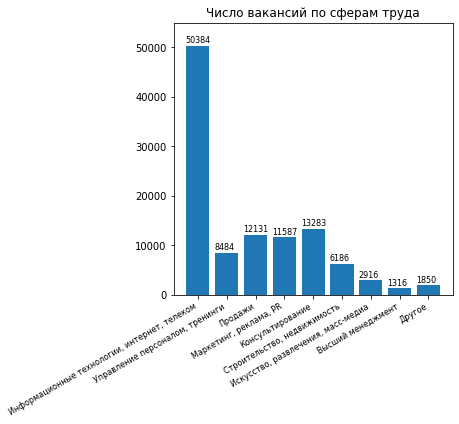

In [11]:
x = ['Информационные технологии, интернет, телеком', 'Управление персоналом, тренинги', \
     'Продажи', 'Маркетинг, реклама, PR', 'Консультирование', 'Строительство, недвижимость', \
     'Искусство, развлечения, масс-медиа', 'Высший менеджмент', 'Другое']
plt.figure(figsize=(5, 5))
plt.bar(profarea_index, profarea_values)
xlocs, xlabs = plt.xticks()
plt.xticks(profarea_index, x, rotation=30, ha='right', fontsize='8')
plt.ylim(None, 55000)
plt.title('Число вакансий по сферам труда', fontsize=12)
for i, v in enumerate(profarea_values):
    plt.text(xlocs[i] - 0.43, v + 600, str(v), fontsize=8)
plt.show()

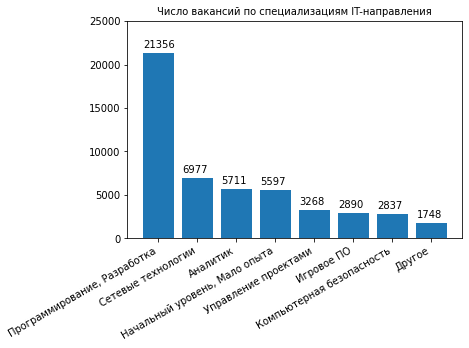

In [12]:
plt.bar(df_s_n_f_vc_index, df_s_n_f_vc_values)
plt.xticks(df_s_n_f_vc_index, rotation=30, ha='right')
plt.ylim(None, 25000)
plt.title('Число вакансий по специализациям IT-направления', fontsize=10)
for i, v in enumerate(df_s_n_f_vc_values):
    plt.text(xlocs[i] - 0.38, v + 600, str(v))
plt.show()

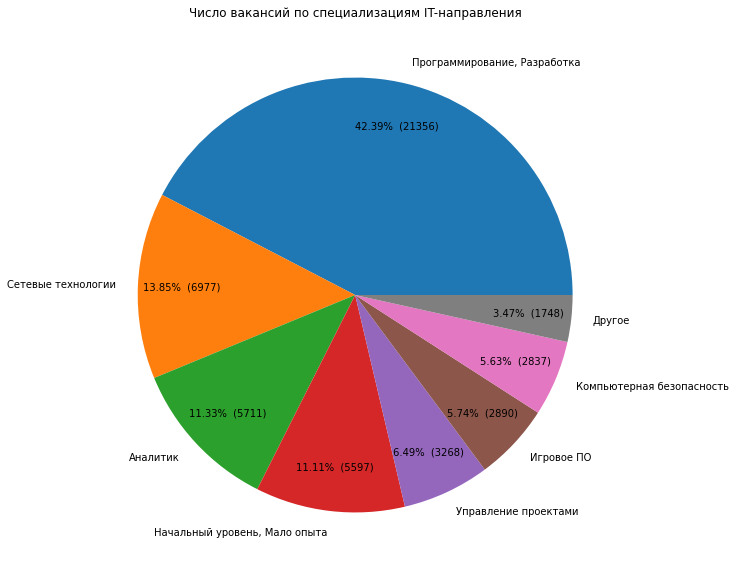

In [13]:
plt.figure(figsize=(10, 10))
plt.style.use('default')
values = df_s_n_f_vc_values 
labels = df_s_n_f_vc_index

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
    return my_autopct

plt.pie(values, labels=labels, autopct=make_autopct(values), pctdistance=0.8)
plt.title('Число вакансий по специализациям IT-направления', fontsize=12)
plt.show()

В случае сфер труда подсчёты по вакансиям проводились не в долевом, а абсолютном измерении, вследствие чего изображены в виде гистограммы. Как видно из расчётов и графиков, число вакансий сферы IT составило 50384 (72% от общего числа вакансий), почти в 4 раза опережая "ближайших преследователей" в виде вакансий консалтинга (13283), продаж (12131) и рекламы (11587). Сферы труда с числом вакансий <1000 были объединены в категорию "Другое" (1850). 

Интересные для данного исследования специальности IT-вакансий представлены в долевом соотношении и потому изображены на круговом графике. Из 50384 IT-вакансий почти половина (21356, 42%) по специальности относится к разработке, 14% (6977 вакансий) - к сетевым технологиям, по 11% к аналитике (5711) и начальным позициям (5597). Порядка 6% занимают вакансии тимлидов, геймдева и компьютерной безопасности. Так же, как и в предыдущем графике, специальности с числом вакансий <1000 были объединены в категорию "Другое" (3.5%, 1748).

Далее можно рассмотреть колонку "region" (Регион).

In [14]:
#df['region'].unique()
#df['region'].describe()
#df['region'].value_counts()
filtered_df_mrot_from['region'].value_counts()

Москва                             6576
Санкт-Петербург                    3230
Краснодарский край                 2217
Московская область                 1456
Свердловская область               1297
                                   ... 
Карачаево-Черкесская Республика       9
Еврейская АО                          6
Республика Калмыкия                   5
Республика Тыва                       4
Республика Ингушетия                  3
Name: region, Length: 82, dtype: int64

Метод .describe() показал, что пропусков в колонке нет, уникальных значений - 84. Метод .value_counts() показал, что крупнейшей число вакансий датасета относится к Москве (20066), на втором месте - Санкт-Петербург (8251), за ним идут Краснодарский край (3166), Свердловская область (2630) и Новосибирская область (2469).

Если посчитать значения регионов на отфильтрованном по МРОТ датасете (по начальной зарплате), то уникальных значений стало 82, число вакансий в Москве сократилось до 6576, в Санкт-Петербурге - 3230, Краснодарский край - 2217. На четвёртое место вышла Московская область с 1456 вакансиями, а Свердловская область стала пятой с 1297 вакансиями.

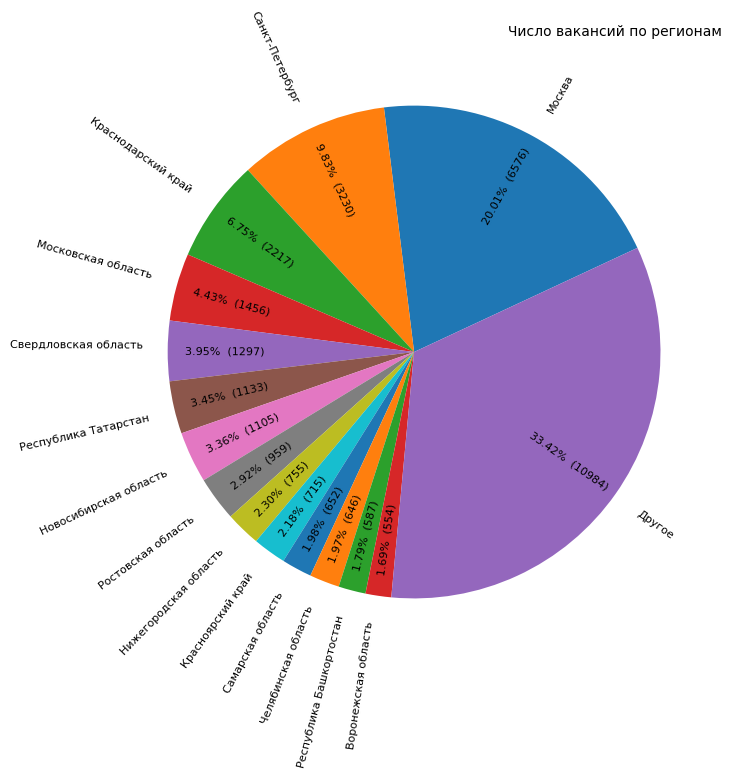

In [15]:
#df_reg = df['region'].value_counts()
df_reg = filtered_df_mrot_from['region'].value_counts()
df_reg_index = df_reg.index
df_reg_values = df_reg.values
df_reg_index_top = df_reg_index[df_reg_values > 500]  # 1000 для неотфильтрованного
df_reg_values_top = df_reg_values[df_reg_values > 500]
df_reg_values_other = sum(df_reg_values[df_reg_values < 500])
df_reg_values_top = np.append(df_reg_values_top, df_reg_values_other)
df_reg_index_top = np.append(df_reg_index_top, 'Другое')
plt.figure(figsize=(8, 8))
patches, labels, pct_texts = plt.pie(df_reg_values_top, labels=df_reg_index_top, 
                                     autopct=make_autopct(df_reg_values_top), 
                                     pctdistance=0.77, rotatelabels=True, textprops={'fontsize': 8},
                                     startangle=25,)  #-10 для неотфильтрованного
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title('Число вакансий по регионам', fontsize=10, loc='right')
plt.show()

Графический анализ с помощью круглой диаграммы показал, что:

1) На неотфильтрованном датасете 14 регионов с числом вакансий >1000 охватывают чуть менее 3/4 всех вакансий. Вакансии остальных 70 регионов (18889) меньше, чем у одной Москвы (20066). Топ-5 регионов охватывают более половины вакансий (52%).

2) На отфильтрованном по МРОТ начальной зарплаты датасете кол-во регионов с числом вакансий >1000 сократилось до 7 (Москва, Санкт-Петербург, Краснодарский край, Московская область, Свердловская область, Татарстан, Новосибирская область); в силу чего было принято решение занести в категорию "Другое" регионы с числом вакансий >500. Регионов с числом вакансий >500 стало снова 14, а регионы с числом вакансий <500 составили чуть больше трети всех вакансий (10984). Лидирует вновь Москва с 1/5 всех вакансий (6576), в два раза меньше в Петербурге (3230) и в три раза меньше в Краснодарском крае (2217). Топ-5 регионов охватывают 45% всех вакансий.

После анализа содержания отобранных для исследования колонок можно заняться анализом взаимосвязи между колонками. 

Сперва можно сопоставить колонки с числовыми и категориальными данными. Начать можно с колонок "Зарплата" и "Опыт работы". Алгоритм:

- Создаётся функция извлечения идентификатора опыта работы из JSON-объекта; 

- Создаётся колонка для считанного в JSON-виде содержания колонки "Опыт работы"; 

- На основе этой колонки создаётся колонка для извлечённых с помощью функции идентификаторов опыта работы;

- Для удобства названия категорий опыта работы переводятся на русский язык циклом и нумеруются по возрастанию стажа (от "Нет опыта" до "Более 6 лет"); 

- Создаётся и применяется фильтр (в силу того, что число вакансий с указанной начальной зарплатой в два раза больше, чем с указанными начальной и конечной зарплатами, было решено сопоставлять колонки с фильтром лишь по начальной зарплате);

- С помощью метода .groupby() производится группировка значений колонок, после чего выводится через метод .describe().

In [16]:
def get_values_id(json):
    try:
        return json['id']
    except:
        return None

df['experience_json'] = df['experience'].fillna('{}').apply(eval)
df['experience_id'] = df['experience_json'].apply(get_values_id)
# df['experience_id'].values
for k in range(len(df['experience_id'])):
    if df['experience_id'].values[k] == 'noExperience':
        df['experience_id'].values[k] = '1) Без опыта'
    elif df['experience_id'].values[k] == 'between1And3':
        df['experience_id'].values[k] = '2) От 1 до 3 лет'
    elif df['experience_id'].values[k] == 'between3And6':
        df['experience_id'].values[k] = '3) От 3 до 6 лет'
    elif df['experience_id'].values[k] == 'moreThan6':
        df['experience_id'].values[k] = '4) Более 6 лет'
    k += 1
filtered_df_mrot_from = df[filter_mrot_from]
filtered_df_mrot_from.groupby('experience_id')['salary_from'].describe()

,count,mean,std,min,25%,50%,75%,max
experience_id,,,,,,,,
1) Без опыта,8820.0,68929.907596,72313.699568,15500.0,32000.0,50000.0,80000.0,1500000.0
2) От 1 до 3 лет,16300.0,68766.366074,50351.651716,15723.0,40000.0,50000.0,80000.0,1500000.0
3) От 3 до 6 лет,7006.0,114536.153868,75147.821471,16000.0,60000.0,100000.0,150000.0,2000000.0
4) Более 6 лет,740.0,147081.006757,103722.907484,20000.0,80000.0,113000.0,180000.0,1000000.0


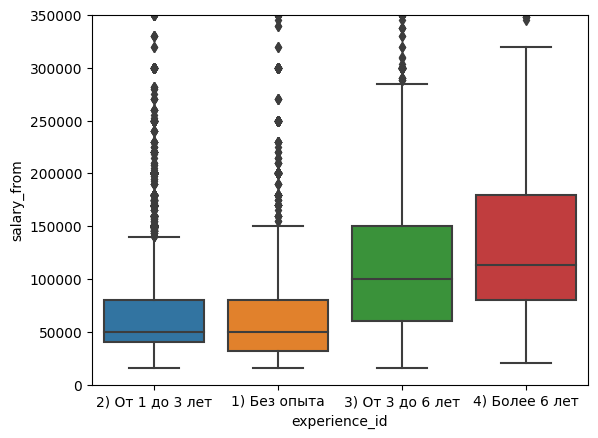

In [17]:
sns.boxplot(x='experience_id', y="salary_from", data=filtered_df_mrot_from) 
plt.axis(ymin=0, ymax=350000)  # лимит по оси ординат
plt.show()

По итогам числового анализа можно сделать вывод, что показатели начальной зарплаты категорий "Без опыта" и "От 1 до 3 лет" примерно одинаковы, с единственным отличием, что первый квартиль зарплат категории "Без опыта" ниже на 20%. Это, с учётом того, что в категории "От 1 до 3 лет" вакансий в два раза больше, говорит о том, что в данной категории больше низкооплачиваемых зарплат (<40000, примерно в два раза больше). Минимальные зарплаты всех категорий отличаются мало (в пределах 5 тыс. рублей), но уже с первого квартиля зарплаты категорий 3) и 4) больше в 1,5-2 раза. По-видимому, нет смысла ориентироваться на максимальные зарплаты в силу их неадекватности (максимальные зарплаты категории "Больше 6 лет" ниже, чем у остальных трёх).

Графический анализ на боксплоте прояснил вопрос с показателями - верхняя граница характерных данных категории "Более 6 лет" проходит на порядка 40000 рублей выше, чем у категории "От 3 до 6 лет" (325000 руб. vs 285000 руб.). Что интересно, при большем разбросе зарплат вниз, по остальным показателям категория "Без опыта" почти полностью сопоставима с категорией "От 1 до 3 лет", а верхняя граница характерных данных даже выше (150000 руб. vs 140000 руб.). Из чего можно сделать вывод, что работодатели готовы платить джунам ненамного больше, чем trainee, при много большем числе предлагаемых вакансий. Наибольший скачок в уровне зарплаты происходит между категориями "От 1 до 3 лет" и "От 3 до 6 лет" - почти в два раза по медиане и третьему квартилю. Поскольку "От 3 до 6 лет" - третья по числу вакансий категория (чуть меньше четверти вакансий), такой скачок говорит об огромной разнице в оценке работодателями навыков junior и middle-специалистов. Фактически, можно сделать вывод, что джуны для работодателей - такое же отребье, как и люди с ~улицы~ проектами на гитхабе.



Далее сопоставим колонки с показателями зарплаты и регионом вакансий.

In [18]:
new_filtered_df_mrot_from = filtered_df_mrot_from
limiter = new_filtered_df_mrot_from['region'].isin(df_reg_index_top)
new_filtered_df_mrot_from = new_filtered_df_mrot_from[limiter]
table = new_filtered_df_mrot_from.groupby('region')['salary_from'].describe().astype(int)
table = table.sort_values('count', ascending=False)
table
#filtered_df_mrot_from.groupby('region')['salary_from'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Москва,6576,109406,71642,16000,60000,90000,150000,700000
Санкт-Петербург,3230,93337,66198,16890,50000,70000,120000,1000000
Краснодарский край,2217,125851,139970,16304,45000,75000,150000,2000000
Московская область,1456,75758,39988,16000,50000,69000,90000,300000
Свердловская область,1297,70823,49303,15973,40000,50000,85000,355000
Республика Татарстан,1133,71947,57102,16700,35000,50000,90000,400000
Новосибирская область,1105,85977,67105,17000,40000,60000,100000,580000
Ростовская область,959,66107,46818,17400,35000,50000,80000,350000
Нижегородская область,755,71854,59209,16000,35000,50000,80000,355000


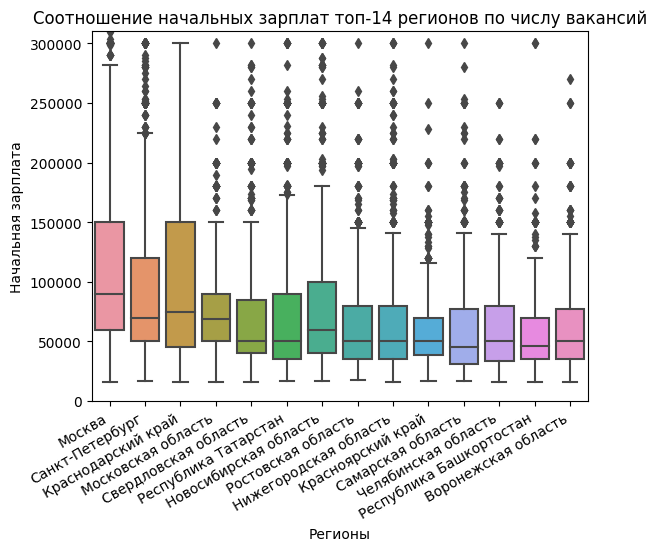

In [19]:
table_order = [item for item in table.index]
ax = sns.boxplot(x='region', y='salary_from', data=new_filtered_df_mrot_from, order=table_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right') 
plt.axis(ymin=0, ymax=310000)  # лимит по оси ординат
plt.title("Соотношение начальных зарплат топ-14 регионов по числу вакансий")
plt.ylabel("Начальная зарплата")
plt.xlabel("Регионы")
plt.show()

In [20]:
other_filtered_df_mrot_from = filtered_df_mrot_from
limiter_other = ~other_filtered_df_mrot_from['region'].isin(df_reg_index_top)
other_filtered_df_mrot_from = other_filtered_df_mrot_from[limiter_other]
table_other = other_filtered_df_mrot_from.groupby('region')['salary_from'].describe().astype(int)
table_other.sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Иркутская область,482,60804,36467,16000,35000,50000,80000,300000
Алтайский край,475,52008,32497,16000,30000,43000,60000,300000
Приморский край,469,70657,36405,20000,50000,60000,80000,280000
Тюменская область,435,66252,40729,20000,40000,55000,80000,355000
Пермский край,428,66325,48471,15723,35000,50000,80000,400000
...,...,...,...,...,...,...,...,...
Карачаево-Черкесская Республика,9,30888,6546,25000,26000,30000,35000,45000
Еврейская АО,6,40833,19893,25000,30750,35000,39250,80000
Республика Калмыкия,5,38776,20558,26000,27000,30883,35000,75000


In [21]:
other_filtered_df_mrot_from['salary_from'].describe().astype(int)

count     10984
mean      59409
std       39536
min       15500
25%       35000
50%       50000
75%       70000
max      400000
Name: salary_from, dtype: int64

Неграфический анализ сопоставления зарплат и регионов вакансий показал, что высокое количество вакансий в целом соответствует высокому уровню зарплат, что демонстрирует, по всей видимости, уровень благосостояния региона. Графический анализ на топ-14 регионов по числу вакансий в целом подтверждает это, демонстрируя нисходящую тенденцию, но из неё сильно выбиваются Краснодарский край (3-е место по числу вакансий) - его третий квартиль равен московскому (1-е место по числу вакансий, а верхняя граница характерных данных даже выше (300000 руб. vs 280000 руб.) - и Новосибирская область (7-е место по числу вакансий), которая по третьему квартилю выходит на 4-е место, а по медиане - на 5-ое. Надо отметить, что у топ-14 регионов медиана ближе к первому квартилю, что говорит о высоком уровне зарплат.

У остальных регионов, у которых число вакансий <500, общие показатели соответствуют нижним регионам из топ-14. В связи с этим было бы любопытно исследовать регионы по медианной зарплате (как наиболее релевантному показателю - максимальные зарплаты могут быть сильно завышены, в силу чего на средние зарплаты опираться нельзя) и проверить, соответствует ли топ регионов по медианной зарплате топу регионов по числу вакансий. Для сравнения так же были взяты топ-14 регионов.

In [22]:
another_filtered_df_mrot_from = filtered_df_mrot_from
another_filtered_df_mrot_from['salary_from'] = another_filtered_df_mrot_from['salary_from'].astype(int)
table_another = another_filtered_df_mrot_from.groupby('region')['salary_from'].describe().astype(int)
table_another_sorted = table_another.sort_values('50%', ascending=False).head(14)
table_another_sorted

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Москва,6576,109406,71642,16000,60000,90000,150000,700000
Республика Адыгея,31,68645,25234,25000,50000,80000,80000,150000
Краснодарский край,2217,125851,139970,16304,45000,75000,150000,2000000
Санкт-Петербург,3230,93337,66198,16890,50000,70000,120000,1000000
Магаданская область,15,77674,25139,47500,60000,70000,97432,120000
Московская область,1456,75758,39988,16000,50000,69000,90000,300000
Новосибирская область,1105,85977,67105,17000,40000,60000,100000,580000
Ленинградская область,134,66737,28697,17000,45000,60000,80000,150000
Республика Саха (Якутия),46,71533,39519,20000,40000,60000,100000,200000


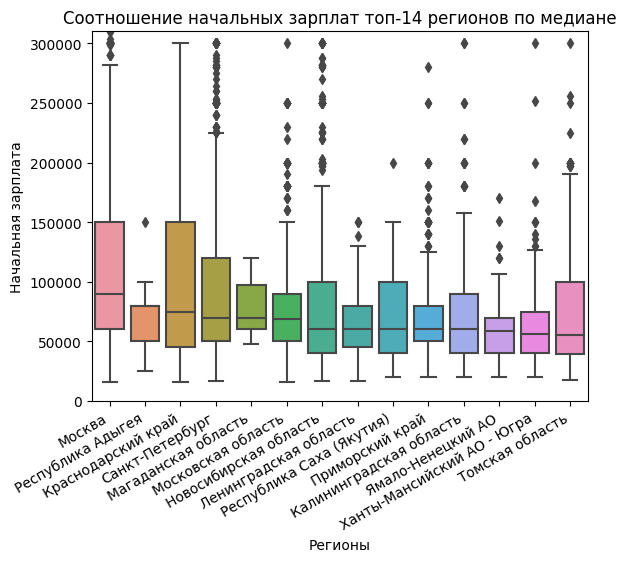

In [23]:
table_another_order = [item for item in table_another_sorted.index]
ax = sns.boxplot(x='region', y='salary_from', data=another_filtered_df_mrot_from, order=table_another_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right') 
plt.axis(ymin=0, ymax=310000)  # лимит по оси ординат
plt.title("Соотношение начальных зарплат топ-14 регионов по медиане")
plt.ylabel("Начальная зарплата")
plt.xlabel("Регионы")
plt.show()

Неграфический анализ демонстрирует, что перечень регионов сильно изменился - так, в него попали 9 регионов с числом вакансий <500, из них 4 региона с числом вакансий <100. 6 из них относятся к регионам Крайнего Севера и приравненным к ним, что может объяснять высокие зарплаты в этих регионах в силу соответственно высоких цен. Самым необычным вхождением в список является Адыгея, у которой при 31 вакансии медианная зарплата равна 80000 рублей, как и третий квартиль. Видимо, большинство из этой 31 вакансии выставило зарплату в 80000 рублей и более. Из топа ушли Свердловская, Ростовская, Нижегородская области и Татарстан.

Графический анализ показывает же, что у Адыгеи, как и у остальных новых попавших в топ-14 по медианной зарплате регионов, разброс зарплат небольшой, а верхняя граница характерных данных не превышает 150000 рублей. Из этой тенденции выбиваются республика Саха, Калининградская область и Томская область. Якутские и томские высокие показатели могут объясняться большими финансовыми вливаниями региональных правительств в IT-сферу, а Калининграда - несколько большей ориентированностью на европейский рынок. ~Но это не точно.~

Таким образом, анализ сопоставления зарплаты и региона вакансий демонстрирует, что число IT-вакансий по региону хорошо соответствует его благосостоянию, в то время как уровень зарплат сильно подвержен влиянию региональной специфики (уровень местных цен, целевое финансирование правительством, сложные климатические условия и пр.) и потому вряд ли может использоваться в качестве опорной точки для анализа. 

Далее исследуем взаимосвязь колонок "Специализация" и "Начальная зарплата".

In [26]:
a1 = filtered_df_mrot_from.groupby(['specializations_profarea_IT'])['salary_from'].describe().astype(int)
a2 = filtered_df_mrot_from.groupby(['specializations_profarea_management'])['salary_from'].describe().astype(int)
a3 = filtered_df_mrot_from.groupby(['specializations_profarea_sales'])['salary_from'].describe().astype(int)
a4 = filtered_df_mrot_from.groupby(['specializations_profarea_marketing'])['salary_from'].describe().astype(int)
a5 = filtered_df_mrot_from.groupby(['specializations_profarea_consulting'])['salary_from'].describe().astype(int)
a6 = filtered_df_mrot_from.groupby(['specializations_profarea_construction'])['salary_from'].describe().astype(int)
a7 = filtered_df_mrot_from.groupby(['specializations_profarea_art'])['salary_from'].describe().astype(int)
a8 = filtered_df_mrot_from.groupby(['specializations_profarea_chief'])['salary_from'].describe().astype(int)
a9 = filtered_df_mrot_from.groupby(['specializations_profarea_other'])['salary_from'].describe().astype(int)

In [27]:
Сфера труда                                   count	 mean	   std 	  min	   25%    50%	    75%	    max
Информационные технологии, интернет, телеком	19264	 86293  63525	 15974	40000	 69000	110000  1000000
Продажи	                                       7460	 96048  87540	 16000	50000	 70000	100000  2000000
Консультирование	                             7279	101574  90228	 16000	50000	 75000	120000	2000000
Строительство, недвижимость	                   5640	100487  95785	 16000	50000	 70000	100000	2000000
Управление персоналом, тренинги	               5162	 48461  26751	 15723	31000	 40000	 60000	 350000
Маркетинг, реклама, PR	                       4363	 70228  50709	 16000	37000	 50000	 85344 	 600000
Искусство, развлечения, масс-медиа	           1345	 60302  40268	 16000	35000	 50000	 70000	 350000
Высший менеджмент	                              587	117568  93901	 20000	70000	100000	130000	1000000
Другое	                                       1125	 50618  49846	 15500	30000	 40000	 55000	 500000

SyntaxError: ignored

Как видно из таблицы, восемь самых популярных по вакансиям сфер труда довольно значимо превосходят по уровню зарплат все остальные; из тенденции выбивается лишь сфера "Управление персоналом, тренинги", чей уровень зарплат сопоставим с менее популярными сферами (равен по медиане, а по среднему значению даже меньше). По всем значениям (кроме максимальных) остальные сферы труда превосходит "Высший менеджмент", у которой при кол-ве вакансий <1000 первый квартиль достигает уже 70000 руб., в то время как для остальных сфер предел 1-го квартиля - 50000 руб.; а медианная зарплата составляет 100000 руб. Что интересно, у сфер "Продажи" и "Строительство, недвижимость" большинство показателей одинаково, однако средняя зарплата второй на 4000 рублей выше, чем у продажников.

Слабая корреляция между представленностью сферы труда и уровнем зарплат среди вакансий отфильтрованного по МРОТ датасета прослеживается: так, у первых четырёх по числу вакансий сфер труда медианная зарплата выше на 20-25 тыс. рублей, а третий квартиль превышает 100000 руб. Однако уровень зарплат сферы IT, самой большой по числу вакансий, уступает зарплатам следующих трёх сфер - возможно, из-за размытости и сильной профилированности IT-индустрии. Понижение зарплат по мере уменьшения числа вакансий происходит неравномерно - сильно выделяется низкими зарплатами сфера "Управление персоналом, тренинги", и высокими - "Высший менеджмент", что обусловлено, по-видимому, специфическими особенностями сфер. Показатели зарплат совокупности слабо представленных в датасете сфер труда продолжают тенденцию к снижению.

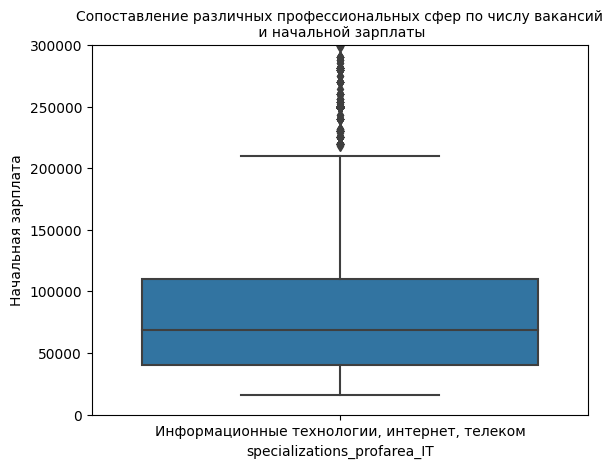

In [28]:
ax1 = sns.boxplot(x='specializations_profarea_IT', y='salary_from', data=filtered_df_mrot_from)
ax1.set_xticklabels(labels=(a1.index), fontsize=10) 
plt.axis(ymin=0, ymax=300000)  # лимит по оси ординат
plt.title("Сопоставление различных профессиональных сфер по числу вакансий\n и начальной зарплаты", fontsize=10)
plt.ylabel("Начальная зарплата")
plt.show()

Графический анализ боксплотов (произведён по отдельности) показал, что, несмотря на численные показатели, самая высокая граница характерные данных по уровню зарплат представлена у сфер IT, консалтинга и высшего менеджмента (>=200000). У всех сфер, кроме высшего менеджмента, медиана сдвинута вниз, ближе к первому квартилю. Из топ-8 сфер самый малый разброс зарплат - у "Управление персоналом, тренинги", самый большой - у "Консультирование". 

Идентичность показателей зарплат сфер "Продажи" и "Строительство, недвижимость" был подтверждён и на графиках, которые тоже отличаются лишь в выбросах. Это может говорить о том, что вакансии этих сфер в основном одни и те же.

Далее можно сопоставить уровень зарплат в специализациях сферы IT.

In [29]:
df['specializations_name_coding'] = pd.Series(np.nan)
df['specializations_name_web'] = pd.Series(np.nan)
df['specializations_name_analysis'] = pd.Series(np.nan)
df['specializations_name_beginner'] = pd.Series(np.nan)
df['specializations_name_teamlead'] = pd.Series(np.nan)
df['specializations_name_gamedev'] = pd.Series(np.nan)
df['specializations_name_security'] = pd.Series(np.nan)
df['specializations_name_director'] = pd.Series(np.nan)
df['specializations_name_techwriter'] = pd.Series(np.nan)
df['specializations_name_other'] = pd.Series(np.nan)
spec_name_list = ['Программирование, Разработка', 'Сетевые технологии', 'Аналитик', \
                  'Начальный уровень, Мало опыта', 'Управление проектами', 'Игровое ПО', \
                  'Компьютерная безопасность', 'CTO, CIO, Директор по IT', 'Технический писатель']
coding_count = web_count = analysis_count = beginner_count = teamlead_count = \
gamedev_count = security_count = director_count = techwriter_count = other_spec_count = 0
for m1 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m1] == 'Программирование, Разработка' or \
       df['specializations_name_filtered_1'][m1] == 'Программирование, Разработка' or \
       df['specializations_name_filtered_2'][m1] == 'Программирование, Разработка' or \
       df['specializations_name_filtered_3'][m1] == 'Программирование, Разработка' or \
       df['specializations_name_filtered_4'][m1] == 'Программирование, Разработка':
        coding_count += 1
        df['specializations_name_coding'][m1] = 'Программирование, Разработка'
    m1 += 1
for m2 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m2] == 'Сетевые технологии' or \
       df['specializations_name_filtered_1'][m2] == 'Сетевые технологии' or \
       df['specializations_name_filtered_2'][m2] == 'Сетевые технологии' or \
       df['specializations_name_filtered_3'][m2] == 'Сетевые технологии' or \
       df['specializations_name_filtered_4'][m2] == 'Сетевые технологии':
        web_count += 1
        df['specializations_name_web'][m2] = 'Сетевые технологии'
    m2 += 1
for m3 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m3] == 'Аналитик' or \
       df['specializations_name_filtered_1'][m3] == 'Аналитик' or \
       df['specializations_name_filtered_2'][m3] == 'Аналитик' or \
       df['specializations_name_filtered_3'][m3] == 'Аналитик' or \
       df['specializations_name_filtered_4'][m3] == 'Аналитик':
        analysis_count += 1
        df['specializations_name_analysis'][m3] = 'Аналитик'
    m3 += 1
for m4 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m4] == 'Начальный уровень, Мало опыта' or \
       df['specializations_name_filtered_1'][m4] == 'Начальный уровень, Мало опыта' or \
       df['specializations_name_filtered_2'][m4] == 'Начальный уровень, Мало опыта' or \
       df['specializations_name_filtered_3'][m4] == 'Начальный уровень, Мало опыта' or \
       df['specializations_name_filtered_4'][m4] == 'Начальный уровень, Мало опыта':
        beginner_count += 1
        df['specializations_name_beginner'][m4] = 'Начальный уровень, Мало опыта'
    m4 += 1
for m5 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m5] == 'Управление проектами' or \
       df['specializations_name_filtered_1'][m5] == 'Управление проектами' or \
       df['specializations_name_filtered_2'][m5] == 'Управление проектами' or \
       df['specializations_name_filtered_3'][m5] == 'Управление проектами' or \
       df['specializations_name_filtered_4'][m5] == 'Управление проектами':
        teamlead_count += 1
        df['specializations_name_teamlead'][m5] = 'Управление проектами'
    m5 += 1
for m6 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m6] == 'Игровое ПО' or \
       df['specializations_name_filtered_1'][m6] == 'Игровое ПО' or \
       df['specializations_name_filtered_2'][m6] == 'Игровое ПО' or \
       df['specializations_name_filtered_3'][m6] == 'Игровое ПО' or \
       df['specializations_name_filtered_4'][m6] == 'Игровое ПО':
        gamedev_count += 1
        df['specializations_name_gamedev'][m6] = 'Игровое ПО'
    m6 += 1
for m7 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m7] == 'Компьютерная безопасность' or \
       df['specializations_name_filtered_1'][m7] == 'Компьютерная безопасность' or \
       df['specializations_name_filtered_2'][m7] == 'Компьютерная безопасность' or \
       df['specializations_name_filtered_3'][m7] == 'Компьютерная безопасность' or \
       df['specializations_name_filtered_4'][m7] == 'Компьютерная безопасность':
        security_count += 1
        df['specializations_name_security'][m7] = 'Компьютерная безопасность'
    m7 += 1
for m8 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m8] == 'CTO, CIO, Директор по IT' or \
       df['specializations_name_filtered_1'][m8] == 'CTO, CIO, Директор по IT' or \
       df['specializations_name_filtered_2'][m8] == 'CTO, CIO, Директор по IT' or \
       df['specializations_name_filtered_3'][m8] == 'CTO, CIO, Директор по IT' or \
       df['specializations_name_filtered_4'][m8] == 'CTO, CIO, Директор по IT':
        director_count += 1
        df['specializations_name_director'][m8] = 'CTO, CIO, Директор по IT'
    m8 += 1
for m9 in range(len(df['specializations'])):
    if df['specializations_name_filtered_0'][m9] == 'Технический писатель' or \
       df['specializations_name_filtered_1'][m9] == 'Технический писатель' or \
       df['specializations_name_filtered_2'][m9] == 'Технический писатель' or \
       df['specializations_name_filtered_3'][m9] == 'Технический писатель' or \
       df['specializations_name_filtered_4'][m9] == 'Технический писатель':
        techwriter_count += 1
        df['specializations_name_techwriter'][m9] = 'Технический писатель'
    m9 += 1
for m10 in range(len(df['specializations'])):
    if (df['specializations_profarea_0'][m10] == 'Информационные технологии, интернет, телеком' or \
       df['specializations_profarea_1'][m10] == 'Информационные технологии, интернет, телеком' or \
       df['specializations_profarea_2'][m10] == 'Информационные технологии, интернет, телеком' or \
       df['specializations_profarea_3'][m10] == 'Информационные технологии, интернет, телеком' or \
       df['specializations_profarea_4'][m10] == 'Информационные технологии, интернет, телеком') and \
       df['specializations_name_filtered_0'][m10] not in spec_name_list and \
       df['specializations_name_filtered_1'][m10] not in spec_name_list and \
       df['specializations_name_filtered_2'][m10] not in spec_name_list and \
       df['specializations_name_filtered_3'][m10] not in spec_name_list and \
       df['specializations_name_filtered_4'][m10] not in spec_name_list:
        other_spec_count += 1
        df['specializations_name_other'][m10] = 'Другое'
    m10 += 1
filtered_df_mrot_from = df[filter_mrot_from]
b1 = filtered_df_mrot_from.groupby(['specializations_name_coding'])['salary_from'].describe().astype(int)
b2 = filtered_df_mrot_from.groupby(['specializations_name_web'])['salary_from'].describe().astype(int)
b3 = filtered_df_mrot_from.groupby(['specializations_name_analysis'])['salary_from'].describe().astype(int)
b4 = filtered_df_mrot_from.groupby(['specializations_name_beginner'])['salary_from'].describe().astype(int)
b5 = filtered_df_mrot_from.groupby(['specializations_name_teamlead'])['salary_from'].describe().astype(int)
b6 = filtered_df_mrot_from.groupby(['specializations_name_gamedev'])['salary_from'].describe().astype(int)
b7 = filtered_df_mrot_from.groupby(['specializations_name_security'])['salary_from'].describe().astype(int)
b8 = filtered_df_mrot_from.groupby(['specializations_name_director'])['salary_from'].describe().astype(int)
b9 = filtered_df_mrot_from.groupby(['specializations_name_techwriter'])['salary_from'].describe().astype(int)
b10 = filtered_df_mrot_from.groupby(['specializations_name_other'])['salary_from'].describe().astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher

In [30]:
Специализация                count	 mean	   std	 min	 25%	  50%	   75%	   max
Программирование, Разработка	8344	106130	65188	16000	58750	 93000	150000	600000
Сетевые технологии	          2978	 67660	47635	16000	40000	 52000	 80000	400000
Начальный уровень, Мало опыта	2746	 44086	23197	17400	27850	 35000	 50000	300000
Аналитик	                    1617	 84921	53902	16000	42500	 70000	120000	400000
Игровое ПО	                  1320	 60311	39732	16000	35000	 50000	 70000	300000
Компьютерная безопасность	     964	 70165	44324	15974	40000	 60000	 90000	350000
Управление проектами	         819	141662	95794	20000	70000	120000	200000	600000
CTO, CIO, Директор по IT	     219	152549 124367	23000	80000	107000	200000 1000000
Технический писатель	         106	 78187	42133	20000	50000	 70000	100000	250000
Другое	                       151	 79231	56145	20000	40000	 60000	100000	300000

SyntaxError: ignored

Числовой анализ сопоставления специализаций вакансий IT-сферы и начальной зарплаты в отфильтрованном по МРОТ и IT-сфере показал, что IT-специализаций с числом вакансий >100 всего 9, а >1000 - только 5. Самый низкий уровень зарплат ожидаемо у специализации "Начальный уровень, Мало опыта", с медианной зарплатой всего в 35000 руб., а третий квартиль - 50000 руб. Т.к. это третья по числу вакансий специализация, очевидно, что начальные позиции в IT-сфере в России оплачиваются низко. В других, уже профессиональных специализациях, наиболее низкий уровень зарплат демонстрирует разработка игр (5-е место по числу вакансий), чьи зарплаты ниже, чем у всех остальных профилей (в том числе, категории "Другое") - медиана 50000, третий квартиль 70000 рублей. Это довольно красноречиво иллюстрирует печальное положение геймдева в России. 

Явной корреляции между числом вакансий и уровнем зарплат по специализациям не проглядывается, два самых высокооплачиваемых профиля - руководительские (тимлиды и директора), с числом вакансий <1000 и медианой >100000 рублей, что вполне ожидаемо от лидерских позиций. Из рядовых профилей выделяются разработчики (1-е место по числу вакансий) - медиана 93000 руб., аналитики (4-е место) - медиана 70000 руб., и технические писатели (9-е место) - медиана 70000 руб. Редкие специализации ("Другое) предлагают вполне конкурентоспособные зарплаты: медиана - 60000, средняя - 79000 рублей. Однако то, что вакансии разработчиков, числом более 8000, в среднем оплачиваются более 100000 рублей, говорит о немалой востребованности данного профиля. На его фоне зарплаты в web-технологии, геймдеве и компьютерной безопасности смотрятся довольно блекло, при довольно большом числе вакансий.

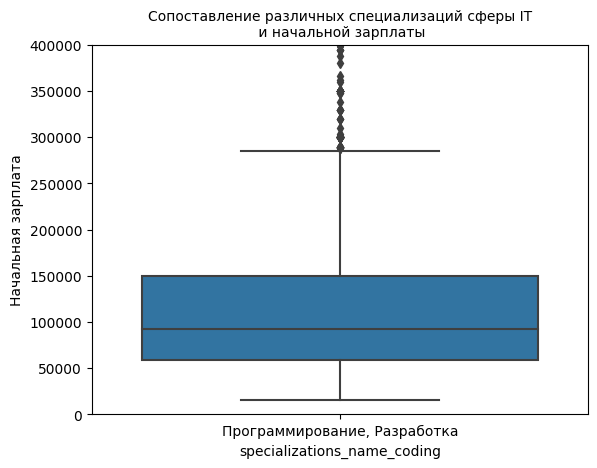

In [31]:
ax2 = sns.boxplot(x='specializations_name_coding', y='salary_from', data=filtered_df_mrot_from)
ax2.set_xticklabels(labels=(b1.index), fontsize=10) 
plt.axis(ymin=0, ymax=400000)  # лимит по оси ординат
plt.title("Сопоставление различных специализаций сферы IT\n и начальной зарплаты", fontsize=10)
plt.ylabel("Начальная зарплата")
plt.show()

Графический анализ, в целом, подтверждает выводы числового; можно выделить три группы специальностей по уровню зарплат: 1) третий квартиль <100000 руб.: "Сетевые технологии", "Начальный уровень", "Игровое ПО" и "Компьютерная безопасность"; 2) третий квартиль от 100000 до 150000 руб.: "Программирование, Разработка", "Аналитик", "Технический писатель" и "Другое"; 3) третий квартиль = 200000 руб.: "Управление проектами", "IT-директор". У профилей первой группы наименьший разброс зарплат, из второй группы к ним по этому аспекту примыкают "Технический писатель" и "Другое", чьи квартили зарплат лежат ровно в пределах 50000-100000 руб. У профилей третьей группы разброс зарплат >100000 руб. Медианы зарплат всех профилей смещены вниз от центра, что говорит о том, что высокооплачиваемые вакансии превалируют. У категорий "Технический писатель" и "Другое", несмотря на принадлежность ко второй группе, верхняя граница характерных данных относительно низка (<200000 руб.), в этом плане к ним примыкает профиль "Компьютерная безопасность". У тимлидов верхняя граница характерных данных даже выше, чем у директоров, но в то же время выше медиана и ниже первый квартиль - т.е., в целом по профилю вакансии директоров оплачиваются лучше.


In [32]:
# Код для проверки проблемы с числом вакансий категории "Другое" (>13000). Проверка
# показала, что были включены вакансии других сфер труда; в силу этого в проверку
# на заполнение колонки "Другое" была добавлена проверка сферы труда.
fdfm_s_n_f = pd.DataFrame()
fdfm_s_n_f['0'] = filtered_df_mrot_from['specializations_name_filtered_0']
fdfm_s_n_f['1'] = filtered_df_mrot_from['specializations_name_filtered_1']
fdfm_s_n_f['2'] = filtered_df_mrot_from['specializations_name_filtered_2']
fdfm_s_n_f['3'] = filtered_df_mrot_from['specializations_name_filtered_3']
fdfm_s_n_f['4'] = filtered_df_mrot_from['specializations_name_filtered_4']
fdfm_s_n_f_vc = fdfm_s_n_f.apply(pd.Series.value_counts)
fdfm_s_n_f_vc = fdfm_s_n_f_vc.fillna(0).astype(int)
fdfm_s_n_f_vc['sum'] = fdfm_s_n_f_vc.sum(axis=1)
fdfm_s_n_f_vc

,0,1,2,3,4,sum
"CTO, CIO, Директор по IT",2,217,0,0,0,219
Web инженер,1,0,0,0,0,1
Аналитик,2,1612,1,2,0,1617
Арт-директор,64,0,0,0,0,64
Банковское ПО,5,0,0,0,0,5
Другое,2,0,0,0,0,2
Игровое ПО,1320,0,0,0,0,1320
Инженер,4,1,1,1,0,7
Компьютерная безопасность,963,1,0,0,0,964
"Консалтинг, Аутсорсинг",1,2,0,0,0,3


Далее осуществим анализ взаимосвязи двух колонок с категориальными данными на примере колонок "Опыт работы" и "Регион".

In [33]:
df_regs = df['region'].value_counts()
df_regs_values = df_regs.values
df_regs_filt = df_regs[df_regs_values > 1000]
df_regs_filt_other = df_regs[df_regs_values < 1000]
filter_regs_other = df['region'].isin(df_regs_filt_other.index)
df_exp_other = df[filter_regs_other]
filter_regs = df['region'].isin(df_regs_filt.index)
df_exp = df[filter_regs]
df_regs_values_other = sum(df_regs_filt_other.values)
regexp = df_exp.groupby('region')['experience_id'].value_counts()
regexp_other = df_exp_other.groupby('region')['experience_id'].value_counts()
regexp_other_gb = regexp_other.groupby(level=1).sum()
regexp_other_gb.index = pd.MultiIndex.from_product([["Другое"], ['1) Без опыта', '2) От 1 до 3 лет', '3) От 3 до 6 лет', '4) Более 6 лет']])
regexp = regexp.append(regexp_other_gb)
regexp.sort_index(level=0)
#regexp.sort_values(ascending=False).sort_index(level='experience_id', sort_remaining=False) # фильтрация по категориям стажа


region                   experience_id   
Воронежская область      1) Без опыта         254
                         2) От 1 до 3 лет     651
                         3) От 3 до 6 лет     268
                         4) Более 6 лет        23
Другое                   1) Без опыта        5170
                         2) От 1 до 3 лет    9644
                         3) От 3 до 6 лет    3714
                         4) Более 6 лет       361
Краснодарский край       1) Без опыта        1220
                         2) От 1 до 3 лет    1346
                         3) От 3 до 6 лет     552
                         4) Более 6 лет        48
Красноярский край        1) Без опыта         259
                         2) От 1 до 3 лет     589
                         3) От 3 до 6 лет     295
                         4) Более 6 лет        47
Москва                   1) Без опыта        1638
                         2) От 1 до 3 лет    9544
                         3) От 3 до 6 лет    7790
        

По числовому анализу сопоставления колонок "Опыт работы" и "Регион", что большинство вакансий любого опыта сосредоточены в Москве и Санкт-Петербурге. Однако, по числу trainee-вакансий (без опыта) на второе место вышел Краснодарский край. По всем уровням опыта на 3-4 местах по вакансиям стоят Свердловская и Новосибирская области. Из других крупных регионов по вакансиям можно выделить Московскую область, но она значимо представлена лишь в вакансиях для новичков и джунов. Заметно, что после столиц, столичной области и Краснодарского края число вакансий без опыта по провинциальным регионам резко падает; из этого можно сделать вывод, что провинциальные работодатели менее готовы обучать сотрудников. Касательно сениорских вакансий, никакой регион, кроме столиц, не предлагает число вакансий больше 100. Что ожидаемо. По количеству джуновских вакансий можно выделить группу регионов с числом вакансий >1000 - помимо столиц, это Свердловская, Новосибирская и Московская области, Краснодарский край и Татарстан. Можно предположить, что это регионы с наиболее активно развивающимся IT-сектором. 

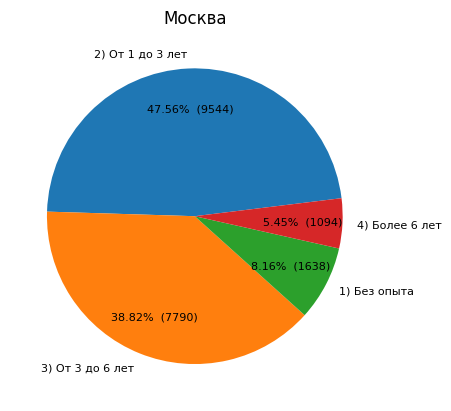

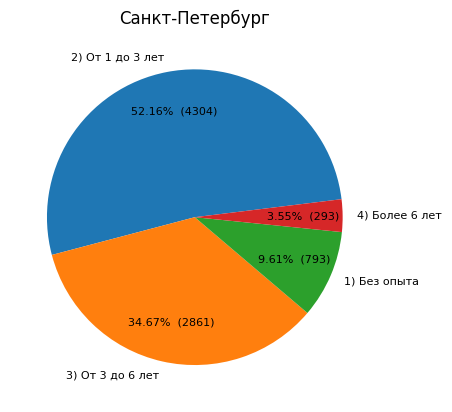

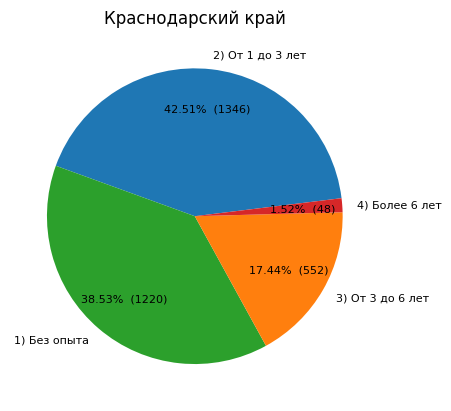

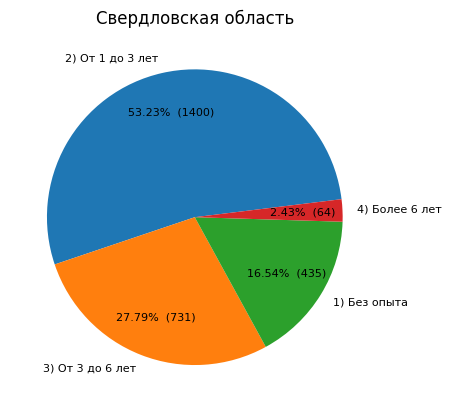

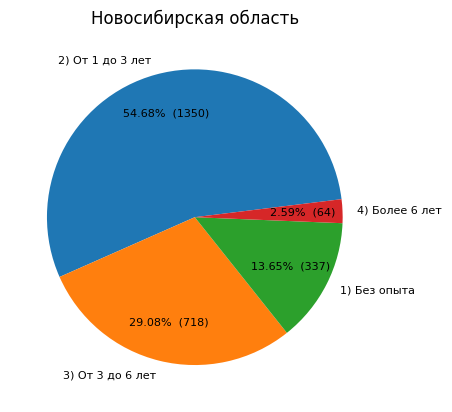

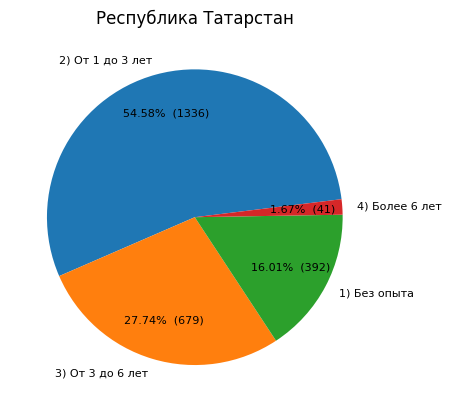

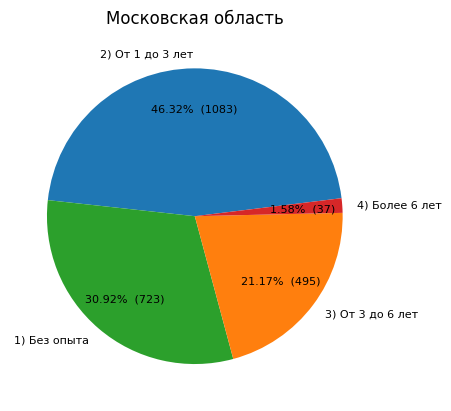

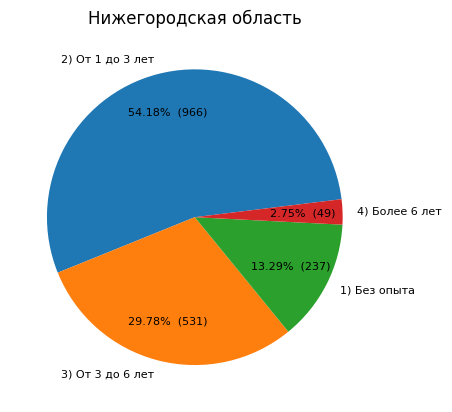

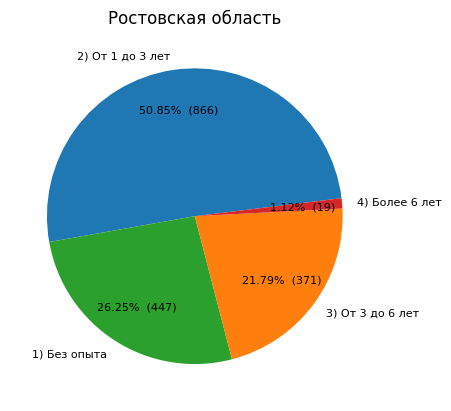

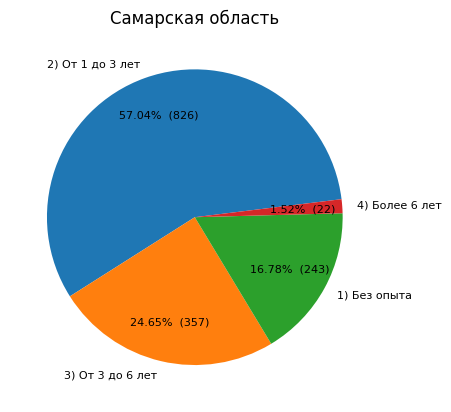

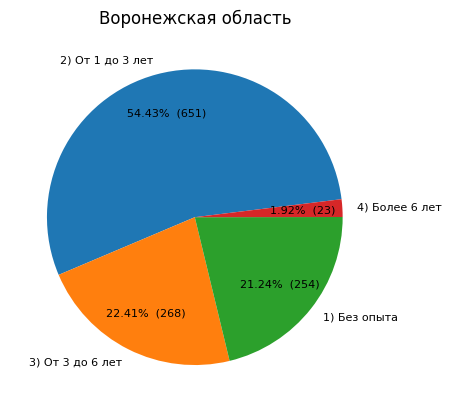

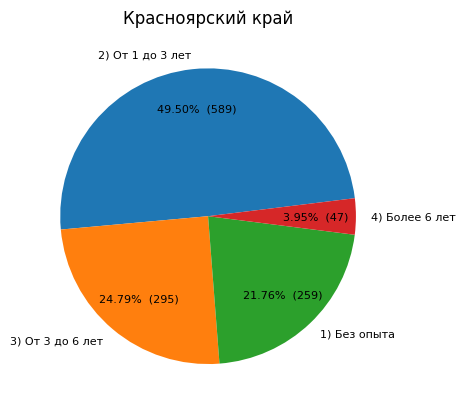

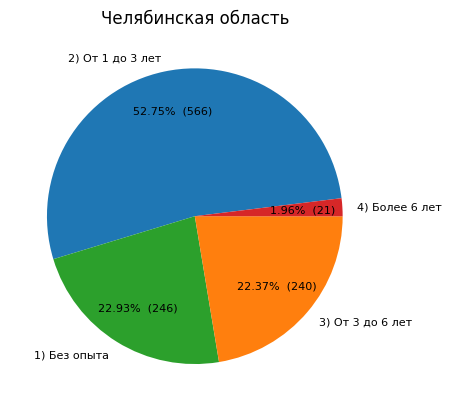

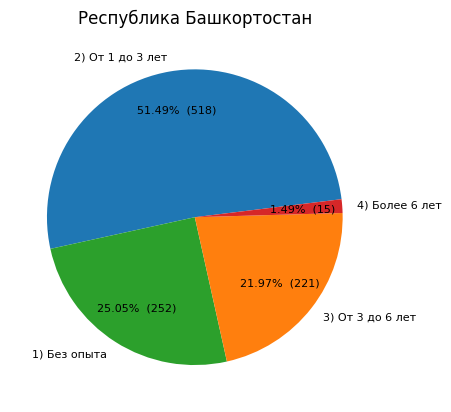

In [34]:
df_exp_reg_vc = df_exp['region'].value_counts()
df_exp_reg_vc.sort_values(ascending=False)
regions = df_exp_reg_vc.index
labels_exp = df_exp['experience_id'].value_counts().index
colors_exp = dict(zip(labels_exp, plt.cm.tab10.colors[:len(labels_exp)])) 
for region in regions:
    df_xyz = df_exp[df_exp['region'] == region]
    exp_counts = df_xyz['experience_id'].value_counts()
    plt.title(region)
    patches, labels, pct_texts = plt.pie(exp_counts.values, labels=exp_counts.index, \
                                         colors=[colors_exp[key] for key in exp_counts.index], \
                                         autopct=make_autopct(exp_counts.values), \
                                         pctdistance=0.73, textprops={'fontsize': 8},
                                         startangle=7)
    plt.show()

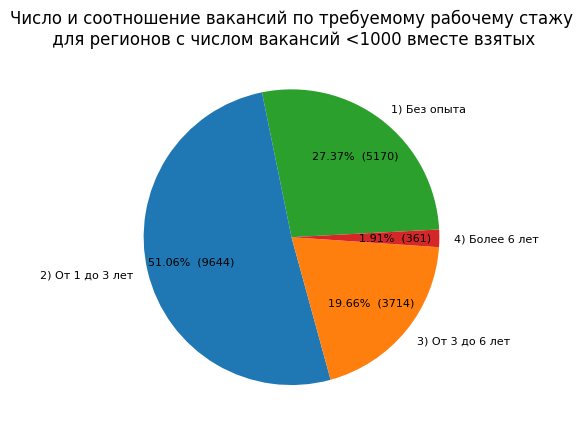

In [35]:
regexp_other_gb_index_list = []
for z in range(len(regexp_other_gb.index)):
    regexp_other_gb_index_list.append(regexp_other_gb.index[z][1])
plt.title('Число и соотношение вакансий по требуемому рабочему стажу\n для регионов с числом вакансий <1000 вместе взятых')
patches, labels, pct_texts = plt.pie(regexp_other_gb.values, labels=regexp_other_gb_index_list, \
                                         colors=[colors_exp[key] for key in regexp_other_gb_index_list], \
                                         autopct=make_autopct(regexp_other_gb.values), \
                                         pctdistance=0.7, textprops={'fontsize': 8},
                                         startangle=3)

Графический анализ сопоставления опыта работы и регионов по числу вакансий демонстрирует, что джуновские вакансии (от 1 до 3 лет опыта) во всех топ-14 регионов занимают долю 50+/-8%, тяготея к половине вакансий среди всех категорий. Из этого можно сделать вывод, что junior-специалисты - наиболее востребованная категория работников IT-сферы в большинстве регионов (по совокупности остальных регионов ситуация та же, 9644 джуновские вакансии против 9245 вакансий всех остальных категорий опыта). В 9 из топ-14 регионов по вакансиям доля миддл-специалистов (от 3 до 6 лет опыта) выше доли вакансий для начинающих работников (в совокупности регионов с малым числом вакансий работы для новичков больше, чем для миддлов: 5170 против 3714). Можно отметить также, что число вакансий для специалистов с опытом более 6 лет в Москве больше, чем почти во всех остальных 83 регионах вместе взятых (1104) - из чего можно сделать вывод, что российские регионы не могут предложить большое число мест для высококлассных специалистов, и они стекаются в Москву.

На этом можно заканчивать разведочный анализ.

Весь код ниже не относится к разведывательному анализу и оставлен в память о мучениях.

In [36]:
def specialization_profarea_set(spec):
    set_spec_1 = set()
    try:
        list_of_dict = eval(spec)
        for elem in list_of_dict:
            set_spec_1.add(elem['profarea_name'])
    except:
        set_spec_1 = set()
    return set_spec_1

def specialization_name_set(spec):
    set_spec_name = set()
    try:
        list_of_dict = eval(spec)
        for elem in list_of_dict:
            set_spec_name.add(elem['name'])
    except:
        set_spec_name = set()
    return set_spec_name

df['specializations_profarea_set'] = df['specializations'].apply(specialization_profarea_set)
df['specializations_name_set'] = df['specializations'].apply(specialization_name_set)
df['specializations_profarea_set'].head(25)

#def spec_profarea(set):
#    for item in set:
#        if item == 'Информационные технологии, интернет, телеком':
#            return item in set

#filter_spec = df['specializations_profarea_set'].apply(spec_profarea)
#filtered_df_spec = df['specializations_profarea_set'].str.contains('Информационные технологии, интернет, телеком', na=False)
#filtered_df_spec


0     {Информационные технологии, интернет, телеком,...
1        {Информационные технологии, интернет, телеком}
2        {Информационные технологии, интернет, телеком}
3        {Информационные технологии, интернет, телеком}
4        {Информационные технологии, интернет, телеком}
5        {Информационные технологии, интернет, телеком}
6        {Информационные технологии, интернет, телеком}
7        {Информационные технологии, интернет, телеком}
8        {Информационные технологии, интернет, телеком}
9        {Информационные технологии, интернет, телеком}
10                    {Управление персоналом, тренинги}
11                    {Управление персоналом, тренинги}
12                    {Управление персоналом, тренинги}
13                    {Управление персоналом, тренинги}
14                    {Управление персоналом, тренинги}
15                    {Управление персоналом, тренинги}
16                    {Управление персоналом, тренинги}
17                    {Управление персоналом, тр

In [37]:
import re

#df['specializations_names'] = [[d['name'] for d in list(ast.literal_eval(row))] for row in df['specializations']]
#df['specializations_profarea_id'] = [[d['profarea_id'] for d in list(ast.literal_eval(row))] for row in df['specializations']]
def get_values_name_1(df):
    for a in df['specializations']:
        for r in (("\'", "\""), ("[", ""), ("]", ""), ("{", ""), ("}", "")):
            a = a.replace(*r)
        a = re.split("\"", a)
        m = 0
        while m < len(a):
            if a[m] in ('', ': ', ', '):
                del a[m]
            m += 1
        a1 = a[0:8]
        a1_keys = a1[::2]
        a1_values = a1[1::2]
        a1_dict = dict(zip(a1_keys, a1_values))
        name1 = a1_dict['name']
        return name1

#def get_values_name_2(df):
#    for a in df['specializations']:
#        for r in (("\'", "\""), ("[", ""), ("]", ""), ("{", ""), ("}", "")):
#            a = a.replace(*r)
#        a = re.split("\"", a)
#        m = 0
#        while m < len(a):
#            if a[m] in ('', ': ', ', '):
#                del a[m]
#            m += 1
#        a2 = a[8:]
#        a2_keys = a2[::2]
#        a2_values = a2[1::2]
#        a2_dict = dict(zip(a2_keys, a2_values))
#        name2 = a2_dict['name']
#        return name2


#df['specializations_name_1'] = df['specializations'].fillna('').apply(get_values_name_1)
#df['specializations_name_2'] = df['specializations'].fillna('').apply(get_values_name_2)
#df['specializations_name_2']


In [38]:
disnulled_salary_from = df['salary_from'].dropna().apply(int)
mean_from = disnulled_salary_from.mean()
df_salary_from_isna = df['salary_from'].isna()
for i in range(len(df_salary_from_isna.values)):
    if df_salary_from_isna.values[i] == True: 
        df['salary_from'].values[i] = 0
        i += 1
df['salary_from'] = df['salary_from'].apply(int)
mean_from_2 = df['salary_from'].mean()
for j in range(len(df['salary_from'])):
    if df['salary_from'].values[j] == 0:
        df['salary_from'].values[j] = mean_from_2
df['salary_from']

0         38135
1         25000
2         38135
3         26000
4         20000
          ...  
69651     38135
69652    130000
69653     50000
69654     85000
69655     38135
Name: salary_from, Length: 69656, dtype: int64

In [39]:
df['salary_to'] = df['salary_json'].apply(get_values_to)
disnulled_salary_to = df['salary_to'].dropna().apply(int)
mean_to = disnulled_salary_to.mean()
df_salary_to_isna = df['salary_to'].isna()
for i in range(len(df_salary_to_isna.values)):
    if df_salary_to_isna.values[i] == True: 
        df['salary_to'].values[i] = mean_to
        i += 1
df['salary_to'].apply(int)

0        131982
1         50000
2        131982
3        131982
4         20000
          ...  
69651    131982
69652    131982
69653    131982
69654    131982
69655    131982
Name: salary_to, Length: 69656, dtype: int64

In [40]:
df['salary_currency'] = df['salary_json'].apply(get_currency)
df['salary_currency'].unique()

array([None, 'RUR', 'USD', 'EUR', 'KZT'], dtype=object)